In [2]:
import cv2
from tensorflow.keras.models import load_model
import numpy as np

from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.inference import load_image
from utils.preprocessor import preprocess_input

In [3]:
# parameters for loading data and images
detection_model_path = 'trained_models/detection_models/haarcascade_frontalface_default.xml'
emotion_model_path = 'trained_models/emotion_models/fer2013_mini_XCEPTION.99-0.65.hdf5'
gender_model_path = 'trained_models/gender_models/simple_CNN.81-0.96.hdf5'
emotion_labels = get_labels('fer2013')
gender_labels = get_labels('imdb')
font = cv2.FONT_HERSHEY_SIMPLEX

# hyper-parameters for bounding boxes shape
gender_offsets = (30, 60)
gender_offsets = (10, 10)
emotion_offsets = (20, 40)
emotion_offsets = (0, 0)

# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
gender_classifier = load_model(gender_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]
gender_target_size = gender_classifier.input_shape[1:3]

In [4]:
res_dic = {
	'angry' : 1,
	'disgust': 2,
	'surprise' : 3,
	'fear': 4,
	'sad' : 5,
	'neutral' : 6,
	'happy' : 7
}
stress_dic = {
	'angry' : 7,
	'disgust': 6,
	'surprise' : 5,
	'sad' : 4,
	'fear': 3,
	'neutral' : 2,
	'happy' : 1
}
res_time = []

In [5]:
cv2.imshow('Video', np.empty((5,5),dtype=float))
compressRate = 1

In [6]:
while cv2.getWindowProperty('Video', 0) >= 0:
    video_capture = cv2.VideoCapture(0)
    ret, img = video_capture.read()
    cv2.imshow("Video", img)

    # image_path = "cache/frame%d.jpg" % count
    image_path = "images/frame.jpg"
    cv2.imwrite(image_path, img)

    # loading images
    rgb_image = load_image(image_path, grayscale=False, color_mode="rgb")
    gray_image = load_image(image_path, grayscale=True, color_mode="grayscale")
    gray_image = np.squeeze(gray_image)
    gray_image = gray_image.astype('uint8')

    faces = detect_faces(face_detection, gray_image)
    for face_coordinates in faces:
        x1, x2, y1, y2 = apply_offsets(face_coordinates, gender_offsets)
        rgb_face = rgb_image[y1:y2, x1:x2]

        x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
        gray_face = gray_image[y1:y2, x1:x2]

        try:
            rgb_face = cv2.resize(rgb_face, (gender_target_size))
            gray_face = cv2.resize(gray_face, (emotion_target_size))
        except:
            continue

        rgb_face = preprocess_input(rgb_face, False)
        rgb_face = np.expand_dims(rgb_face, 0)
        gender_prediction = gender_classifier.predict(rgb_face)
        gender_label_arg = np.argmax(gender_prediction)
        gender_text = gender_labels[gender_label_arg]

        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0)
        gray_face = np.expand_dims(gray_face, -1)
        emotion_label_arg = np.argmax(emotion_classifier.predict(gray_face))
        emotion_text = emotion_labels[emotion_label_arg]

        if gender_text == gender_labels[0]:
            color = (0, 0, 255)
        else:
            color = (255, 0, 0)

        draw_bounding_box(face_coordinates, rgb_image, color)
        draw_text(face_coordinates, rgb_image, gender_text, color, 0, -20, 1, 2)
        draw_text(face_coordinates, rgb_image, emotion_text, color, 0, -50, 1, 2)

        res_time.append(emotion_text)

    bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    # plt.imshow(bgr_image)
    cv2.imwrite('images/trained_model_test.png', bgr_image)

    cv2.imshow("Result", cv2.imread('images/trained_model_test.png'))

    cv2.waitKey(1)
    video_capture.release()


C:\Users\ankur\.virtualenvs\emotions_detection-6_OX7kwt\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


KeyboardInterrupt: 

In [6]:
video_capture.release()
cv2.destroyAllWindows()

Text(0.5, 0, 'Time(s)')

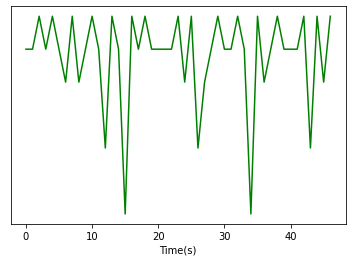

In [7]:
import matplotlib.pyplot as plt
plt.plot([res_dic[emotion] for emotion in res_time], 'green')
plt.yticks([])
plt.xlabel("Time(s)")

Text(0, 0.5, 'Emotions')

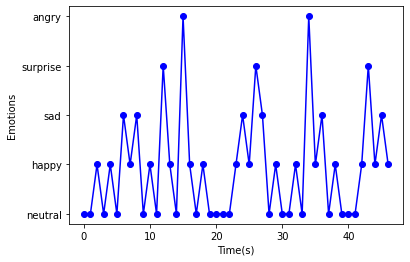

In [8]:
plt.plot(res_time, 'bo-')
plt.xlabel("Time(s)")
plt.ylabel("Emotions")

([], [])

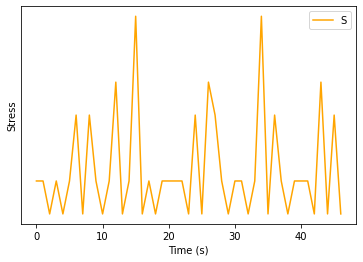

In [9]:
plt.plot([stress_dic[emotion] for emotion in res_time], 'orange')
plt.ylabel("Stress")
plt.xlabel("Time (s)")
plt.legend("Stress")
plt.yticks([])